In [ ]:
#to mount on drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#run to clear the colab runtime data
import shutil
import os

for filename in os.listdir('/content'):
    file_path = os.path.join('/content', filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')


In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="replace_with_your_roboflowkey")
project = rf.workspace("indian-institute-of-information-technology-kancheepuram").project("crop-and-weed-project")
version = project.version(1)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Crop-and-Weed-Project-1 in yolov5pytorch:: 100%|██████████| 6112/6112 [00:01<00:00, 3535.05it/s]


In [ ]:
# Move dataset to Google Drive
!mv /content/Crop-and-Weed-Project-1 /content/drive/MyDrive/

# Set base directory to the dataset folder in Google Drive
base_dir = "/content/drive/MyDrive/Crop-and-Weed-Project-1"


In [ ]:
#move just the valid folder cuz renaming issue
import shutil
base_dir = "/content/drive/MyDrive/Crop-and-Weed-Project-1"
colab_path = "/content/Crop-and-Weed-Project-1"
if os.path.exists(f"{colab_path}/val"):
    shutil.move(f"{colab_path}/val", f"{base_dir}/valid")
    print("Moved and renamed val to valid")
elif os.path.exists(f"{colab_path}/valid"):
    shutil.move(f"{colab_path}/valid", f"{base_dir}/valid")
    print("Moved valid to Google Drive")

Moved valid to Google Drive


In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install supervision opencv-python matplotlib

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-y57u0rau
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-y57u0rau
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth


--2025-04-19 07:24:32--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.176.44, 18.238.176.115, 18.238.176.126, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   114MB/s    in 3.1s    

2025-04-19 07:24:36 (114 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]



In [ ]:
from segment_anything import sam_model_registry, SamPredictor
import torch

sam_checkpoint = "sam_vit_b.pth"
model_type = "vit_b"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [ ]:
# running model for just 10 images just to see if eveything is correctly done till now,just to test
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from segment_anything import SamPredictor

# Base setup
base_dir = "/content/drive/MyDrive/Crop-and-Weed-Project-1"
splits = ["train", "valid", "test"]

def yolo_to_xyxy(bbox, img_w, img_h):
    cx, cy, w, h = bbox
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return [int(x1), int(y1), int(x2), int(y2)]

# Modify to process only the first 10 images for testing
num_images_to_process = 300  # Limit to 10 images

# Loop through each split
for split in splits:
    print(f"\nProcessing split: {split}")
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    output_dir = os.path.join(base_dir, split, "segment_labels")
    os.makedirs(output_dir, exist_ok=True)

    # Only select the first 10 images for testing
    img_paths = sorted(glob(f"{img_dir}/*.jpg"))[:num_images_to_process]

    for img_path in tqdm(img_paths, desc=f"{split} images"):
        img = cv2.imread(img_path)
        if img is None:
            continue

        predictor.set_image(img)
        h, w, _ = img.shape

        base = os.path.basename(img_path).replace(".jpg", "")
        label_path = os.path.join(label_dir, f"{base}.txt")
        out_path = os.path.join(output_dir, f"{base}.txt")

        # Skip if label file doesn't exist
        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        output_lines = []
        for line in lines:
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            box = yolo_to_xyxy([cx, cy, bw, bh], w, h)

            input_box = np.array(box)
            masks, scores, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False
            )

            mask = masks[0]
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                biggest = max(contours, key=cv2.contourArea)
                norm_pts = []
                for pt in biggest:
                    x, y = pt[0]
                    norm_pts.extend([x / w, y / h])
                output_lines.append(f"{int(cls)} " + " ".join([str(p) for p in norm_pts]))

        with open(out_path, 'w') as f:
            f.write("\n".join(output_lines))



Processing split: train


train images:   2%|▏         | 7/300 [04:22<3:03:04, 37.49s/it]


KeyboardInterrupt: 

In [ ]:
#did only for 200 images form test and train, and 130 images from valid (dont have time to do for 2600 images)
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from segment_anything import SamPredictor

# ✅ Set base directory on Google Drive
base_dir = "/content/drive/MyDrive/Crop-and-Weed-Project-1"
splits = ["train", "valid", "test"]

def yolo_to_xyxy(bbox, img_w, img_h):
    cx, cy, w, h = bbox
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return [int(x1), int(y1), int(x2), int(y2)]

# 🔄 Loop through each split
for split in splits:
    print(f"\n🔄 Resuming split: {split}")
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    output_dir = os.path.join(base_dir, split, "segment_labels")
    os.makedirs(output_dir, exist_ok=True)

    img_paths = sorted(glob(f"{img_dir}/*.jpg"))

    # ✅ Filter only unprocessed images
    unprocessed = []
    for img_path in img_paths:
        base = os.path.basename(img_path).replace(".jpg", "")
        out_path = os.path.join(output_dir, f"{base}.txt")
        if not os.path.exists(out_path):
            unprocessed.append(img_path)

    print(f"📝 Found {len(unprocessed)} unprocessed images in '{split}'")

    # ✅ Only process first 200
    unprocessed = unprocessed[:200]

    for img_path in tqdm(unprocessed, desc=f"{split} (resuming up to 200)"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"⚠️ Could not read image: {img_path}")
                continue

            predictor.set_image(img)

            h, w, _ = img.shape

            base = os.path.basename(img_path).replace(".jpg", "")
            label_path = os.path.join(label_dir, f"{base}.txt")
            out_path = os.path.join(output_dir, f"{base}.txt")

            if not os.path.exists(label_path):
                print(f"⚠️ Label missing: {label_path}")
                continue

            with open(label_path, 'r') as f:
                lines = f.readlines()

            output_lines = []
            for line in lines:
                cls, cx, cy, bw, bh = map(float, line.strip().split())
                box = yolo_to_xyxy([cx, cy, bw, bh], w, h)

                input_box = np.array(box)
                try:
                    masks, scores, _ = predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box[None, :],
                        multimask_output=False
                    )
                except Exception as e:
                    print(f"⚠️ Prediction failed for {img_path}: {e}")
                    continue

                mask = masks[0]
                contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    biggest = max(contours, key=cv2.contourArea)
                    norm_pts = []
                    for pt in biggest:
                        x, y = pt[0]
                        norm_pts.extend([x / w, y / h])
                    output_lines.append(f"{int(cls)} " + " ".join([str(p) for p in norm_pts]))

            # ✅ Ensure output directory exists in case it was deleted
            os.makedirs(os.path.dirname(out_path), exist_ok=True)

            with open(out_path, 'w') as f:
                f.write("\n".join(output_lines))

        except Exception as e:
            print(f"❌ Unexpected error for {img_path}: {e}")
            continue



🔄 Resuming split: train
📝 Found 2660 unprocessed images in 'train'


train (resuming up to 200): 100%|██████████| 200/200 [1:45:59<00:00, 31.80s/it]



🔄 Resuming split: valid
📝 Found 260 unprocessed images in 'valid'


valid (resuming up to 200): 100%|██████████| 200/200 [1:47:04<00:00, 32.12s/it]



🔄 Resuming split: test
📝 Found 130 unprocessed images in 'test'


test (resuming up to 200): 100%|██████████| 130/130 [1:10:18<00:00, 32.45s/it]


In [ ]:
#for the entire dataset (all 2600 images)
#change the path to drive folder path
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
from segment_anything import SamPredictor

# Base setup
base_dir = "Crop-and-Weed-Project-1"
splits = ["train", "valid", "test"]

def yolo_to_xyxy(bbox, img_w, img_h):
    cx, cy, w, h = bbox
    x1 = (cx - w / 2) * img_w
    y1 = (cy - h / 2) * img_h
    x2 = (cx + w / 2) * img_w
    y2 = (cy + h / 2) * img_h
    return [int(x1), int(y1), int(x2), int(y2)]

# Loop through each split
for split in splits:
    print(f"\nProcessing split: {split}")
    img_dir = os.path.join(base_dir, split, "images")
    label_dir = os.path.join(base_dir, split, "labels")
    output_dir = os.path.join(base_dir, split, "segment_labels")
    os.makedirs(output_dir, exist_ok=True)

    img_paths = sorted(glob(f"{img_dir}/*.jpg"))

    for img_path in tqdm(img_paths, desc=f"{split} images"):
        img = cv2.imread(img_path)
        if img is None:
            continue

        predictor.set_image(img)
        h, w, _ = img.shape

        base = os.path.basename(img_path).replace(".jpg", "")
        label_path = os.path.join(label_dir, f"{base}.txt")
        out_path = os.path.join(output_dir, f"{base}.txt")

        # Skip if label file doesn't exist
        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            lines = f.readlines()

        output_lines = []
        for line in lines:
            cls, cx, cy, bw, bh = map(float, line.strip().split())
            box = yolo_to_xyxy([cx, cy, bw, bh], w, h)

            input_box = np.array(box)
            masks, scores, _ = predictor.predict(
                point_coords=None,
                point_labels=None,
                box=input_box[None, :],
                multimask_output=False
            )

            mask = masks[0]
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if contours:
                biggest = max(contours, key=cv2.contourArea)
                norm_pts = []
                for pt in biggest:
                    x, y = pt[0]
                    norm_pts.extend([x / w, y / h])
                output_lines.append(f"{int(cls)} " + " ".join([str(p) for p in norm_pts]))

        with open(out_path, 'w') as f:
            f.write("\n".join(output_lines))


ModuleNotFoundError: No module named 'segment_anything'

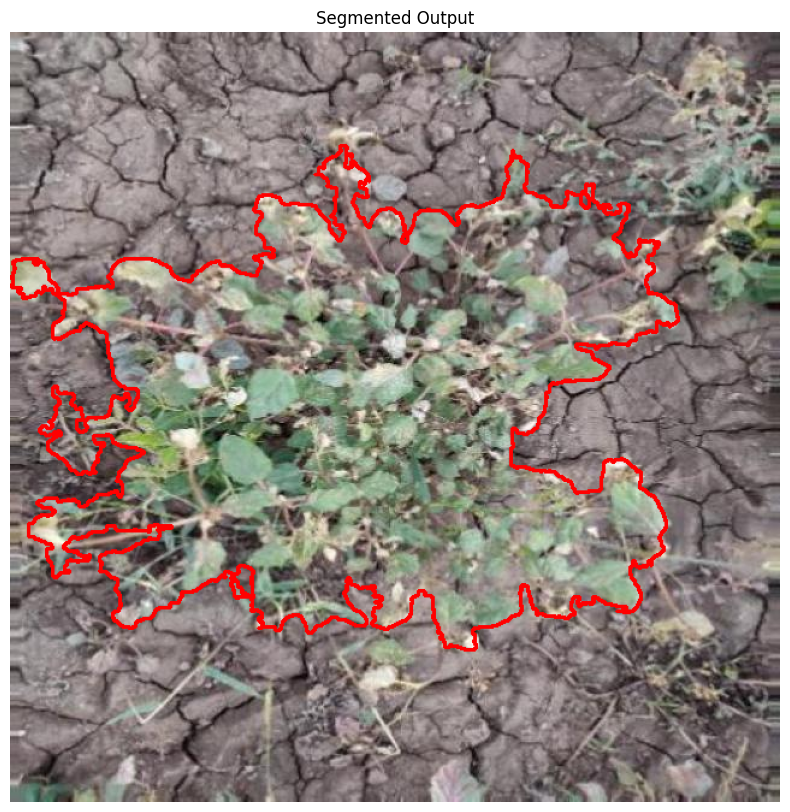

In [ ]:
#to view one segmented ouput
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Paths to image and corresponding label file (NO trailing space!)
#change the path to drive folder path
img_path = "/content/Crop-and-Weed-Project-1/test/images/agri_0_1018_jpeg.rf.bef081a6b0d27f15cb72f53e15122f52.jpg"
label_path = "/content/Crop-and-Weed-Project-1/test/segment_labels/agri_0_1018_jpeg.rf.bef081a6b0d27f15cb72f53e15122f52.txt"

# Read image
img = cv2.imread(img_path)

# Check if image loaded correctly
if img is None:
    raise FileNotFoundError(f"Failed to load image from: {img_path}")

# Read the segmentation label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Draw polygons from segmentation points
for line in lines:
    # Skip the class index and convert rest to float
    points = list(map(float, line.strip().split()[1:]))
    # Reshape to Nx2 and scale to image dimensions
    pts = np.array(points).reshape(-1, 2)
    pts = (pts * [img.shape[1], img.shape[0]]).astype(int)
    # Draw polygon
    cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 255), thickness=2)

# Display the image with overlays
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Segmented Output")
plt.show()
